# Singularly Perturbed Equations

## Boundary layers
Consider the linear 2-point boundary value problem
$$ \begin{array}{c}a u'(x) = \kappa u''(x) + \psi(x), \\
 u(0) = \alpha, \quad u(1) = \beta. \end{array}$$
    If $a$ is small relative to $\kappa$􏰭, then this problem is easy to solve.  Now, suppose $a$ is large relative to $\kappa$.  Here, we introduce a parameter $\epsilon = \frac{\kappa}{a}$, and rewrite the above equation in the form
$$ \epsilon u''(x) - u'(x) = f(x).$$
Then taking $a$ large relative to $\kappa$ corresponds to the case $\epsilon \ll 􏰱1$.􏰭 

__Example__:
Considering
$$ \begin{array}{c}\epsilon u''(x) - u'(x) = f(x), \\
 u(0) = \alpha, \quad u(1) = \beta. \end{array}$$
Here, $\alpha = 1$, $\beta=3$, and $f(x) = -1$.  In this case the exact solution (why?) is
$$ u(x) = \alpha + x + \beta + (\beta - \alpha -1)\left(\frac{e^{x/\epsilon} -1}{e^{1/\epsilon}-1}\right) $$


In [361]:
#%matplotlib notebook
%matplotlib inline

# environment setting, before any codes
import numpy as np
import scipy.linalg as slinalg

import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output, display

In [362]:
def exact_fun(x, alpha, beta, epsilon):
    return alpha + x + (beta - alpha - 1)*((np.exp(x/epsilon)-1)/(np.exp(1/epsilon)-1))

alpha = 1
beta = 3
epsilon = 0.002

number = 101
def draw_fun(number, alpha, beta, epsilon):
    x = np.linspace(0, 1, number)
    y = exact_fun(x, alpha, beta, epsilon)
    plt.plot(x,y,'r',linewidth=2)
    return epsilon
#draw_fun(number, alpha, beta, epsilon)
w = interactive(draw_fun, number=fixed(number), alpha=fixed(alpha), beta=fixed(beta),\
                epsilon=widgets.FloatSlider(min=0.01,max=1.00,step=0.01, value=1.00, description='$\epsilon:$',))
display(w)

interactive(children=(FloatSlider(value=1.0, description='$\\epsilon:$', max=1.0, min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

Note that as $\epsilon \rightarrow 0$􏰫 the solution tends toward a discontinuous function that jumps to the value $\beta$ at the last possible moment.  This region of rapid transition is called the _boundary layer_ and it can be shown that for this problem the width of this layer is $\mathcal{O}(\epsilon)$ as $\epsilon \rightarrow 0$.

The above equation with $0 < \epsilon \ll 1$ is called a _singularly perturbed equation_. It is a small perturbation of equation $-u'(x) = f(x)$, but this small perturbation completely changes the character of the equation (from a first order to a second order equation). Typically any differential equation having a small parameter multiplying the highest order derivative will give a singular perturbation problem.

### Finite Difference Methods
This _singularly perturbed equation_ can be discretized to second order by
$$ \epsilon\left(\frac{U_{i+1} - 2U_i + U_{i-1}}{h^2}\right) - \left(\frac{U_{i+1} - U_{i-1}}{2h}\right) = f_i, \qquad i = 1,\ldots, m,$$
with $U_0 = \alpha$ and $U_{m+1} = \beta$.  This gives the linear system $AU = F$, where $U$ is the vector of unknowns $U = [U_0, U_1, \ldots, U_m, U_{m+1}]^T$, $A$ is the tridiagonal matrix
$$
    A = \frac{1}{h^2}\left[\begin{array}{cccccccc}
    h^2  &  0 &   &    &   &    & & \\
    \epsilon + h/2  & -2\epsilon &  \epsilon - h/2 &    &   &    & &\\
       &  \epsilon + h/2  & -2\epsilon &  \epsilon - h/2 &   &    & &\\ 
       &    &  \epsilon + h/2  & -2\epsilon &  \epsilon - h/2 &    & &\\
       &    & & \ddots & \ddots &\ddots & &\\
       &    &    &    & \epsilon + h/2  & -2\epsilon &  \epsilon - h/2  &\\
       &    &    &    &   &  \epsilon + h/2  & -2\epsilon &  \epsilon - h/2 \\
       &    &    &    &   &   &  0 & h^2\end{array}\right],
           \quad
   \text{and}\quad F = \left[\begin{array}{c} \alpha \\ f_1\\ f_2 \\ f_3 \\ \vdots \\ f_{m-1} \\ f_m \\ \beta\end{array}\right]. 
$$

In [363]:
def generate_grid(left, right, m):
    h = (right - left)/(m+1)
    x = np.zeros(m+2)
    for j in range(m+2):
        x[j] = j*h
    return  x, h

def generate_A_interior(epsilon, h, m):
    A = np.zeros([m+2, m+2])
    for i in range(1,m+1):
        A[i, i-1] = epsilon + h/2.
        A[i, i] = -2*epsilon
        A[i, i+1] = epsilon - h/2
    #A[1:m+1,1:m+1] = - 2*np.eye(m, m) 
    #A[ += np.eye(m+2, m+2, -1) + np.eye(m+2, m+2, 1)
    return A/h**2

def generate_F_interior(m, x, fun):
    F = np.zeros(m+2)
    for i in range(1,m+1):
        F[i] = fun(x[i])
    return F

def Dirichlet_bc(A, F, alpha, beta, fun):
    A[0,0] = 1
    A[-1,-1] = 1
    F[0] = alpha
    F[-1] = beta
    return A, F

def fun(x):
    return -1

def FDM_BVP(m, left, right, alpha, beta, epsilon, bc, fun, exact_fun):
    # generate the grid
    x, h = generate_grid(left, right, m)
    #
    U = np.zeros(m+2)
    # 
    A = generate_A_interior(epsilon, h, m)
    #print (A)
    F = generate_F_interior(m, x, fun)
    #print (F)
    # bc
    A, F = bc(A, F, alpha, beta, fun)
    #print (A)
    #print (F)
    U = np.linalg.solve(A, F)
    
    u = exact_fun(x, alpha, beta, epsilon)
    return np.max(np.abs(U-u)), x, U, u

max norm error: 6.96e-01


0.01

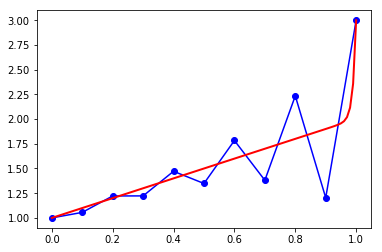

In [364]:
alpha = 1
beta = 3
epsilon = 0.01
error, x, U, u = FDM_BVP(9, 0, 1, alpha, beta, epsilon, Dirichlet_bc, fun, exact_fun)

print ("max norm error: %7.2e" % error )
# let us plot the approximation solution in blue, and the exact solution in red
#plt.plot(x, u, 'ro-')
plt.plot(x, U, 'bo-')
number = 101
draw_fun(number, alpha, beta, epsilon)

In [365]:
def draw_appximation(m, epsilon):
    error, x, U, u = FDM_BVP(m, 0, 1, alpha, beta, epsilon, Dirichlet_bc, fun, exact_fun)
    print ("max norm error: %7.2e" % error )
    # let us plot the approximation solution in blue, and the exact solution in red
    #plt.plot(x, u, 'ro-')
    plt.plot(x, U, 'bo-')
    number = 101
    draw_fun(number, alpha, beta, epsilon)
    
#draw_appximation(9, 0.01)
w = interactive(draw_appximation, m=widgets.IntSlider(min=9,max=2000,step=10, value=9, description='$m:$',),\
                epsilon=widgets.FloatSlider(min=0.01,max=1.00,step=0.01, value=1.00, description='$\epsilon:$',))
display(w)

interactive(children=(IntSlider(value=9, description='$m:$', max=2000, min=9, step=10), FloatSlider(value=1.0, description='$\\epsilon:$', max=1.0, min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

In [366]:
levels = 9
m = np.array([9, 19, 39, 79, 159, 319, 639, 1279, 177], int)
err_max = np.zeros(levels)
print ('   h      max error   order  ')
for i in range (levels):
    err_max[i],_,_,_ = FDM_BVP(m[i], 0, 1, alpha, beta, epsilon, Dirichlet_bc, fun, exact_fun)
    if (err_max[i] < 0.01):
        print ("yes")
    if (i == 0):
        print ('%7.2e  %7.2e' % (1/(m[i]+1), err_max[i]))
    else:
        print ('%7.2e  %7.2e    %4.2f' % (1/(m[i]+1), err_max[i], \
                                        np.log(err_max[i-1]/err_max[i])/np.log((m[i]+1)/(m[i-1]+1))))

   h      max error   order  
1.00e-01  6.96e-01
5.00e-02  4.35e-01    0.68
2.50e-02  1.93e-01    1.17
1.25e-02  5.57e-02    1.79
6.25e-03  1.21e-02    2.20
yes
3.13e-03  3.02e-03    2.01
yes
1.56e-03  7.49e-04    2.01
yes
7.81e-04  1.87e-04    2.00
yes
5.62e-03  9.93e-03    2.01


## Nonuniform Mesh 

### A general approach to deriving the coefficients
For computing the finite difference coefficients for computing an approximation to $u^{(k)}(\bar{x})$, the $k$th derivative of $u(x)$ evaluated at $\bar{x}$, based on an arbitrary stencil of $n \geq 􏰇k+1$ points $x_1, \ldots, x_n$. We assume $u(x)$ is sufficiently smooth, so that the Taylor series expansions of $u$ at each point $x_i$ in the stencil about $u(\bar{x})$ yield
$$u\left(x_{i}\right)=u(\bar{x})+\left(x_{i}-\bar{x}\right) u^{\prime}(\overline{x})+\cdots+\frac{1}{k !}\left(x_{i}-\bar{x}\right)^{k} u^{(k)}(\bar{x})+\cdots$$
for $i = 1,\ldots, n$.  We want to find a linear combination of these values that agrees with $u^{(k)}(\bar{x})$ as well as possible. So we want
$$ c_{1} u\left(x_{1}\right)+c_{2} u\left(x_{2}\right)+\cdots+c_{n} u\left(x_{n}\right)=u^{(k)}(\bar{x})+O\left(h^{p}\right) $$
where $p$ is as large as possible. (Here $h$ is some measure of the width of the stencil)

In [367]:
from math import factorial
def fdcoeff(k, xbar, x):
    n = np.size(x)
    if (n < k+1): 
        print ("Try again!")
        exit
    A = np.ones([n,n])
    xrow = x - xbar
    for i in range(1,n):
        A[i,:] = xrow**(i)/factorial(i)
    b = np.zeros(n)
    b[k] = 1
    c = np.linalg.solve(A,b)
    return c   

In [368]:
c = fdcoeff(1, 0, np.array([-1,0,1]))
print (c)

[-0.5  0.   0.5]


In [369]:
def generate_A_interior_nonuni(epsilon, m, x):
    A = np.zeros([m+2, m+2])
    for i in range(1,m+1):
        c = fdcoeff(2, x[i], x[i-1:i+2])
        b = fdcoeff(1, x[i], x[i-1:i+2])
        A[i, i-1:i+2] = epsilon*c - b 
    #A[1:m+1,1:m+1] = - 2*np.eye(m, m) 
    #A[ += np.eye(m+2, m+2, -1) + np.eye(m+2, m+2, 1)
    return A

def FDM_BVP(m, left, right, alpha, beta, epsilon, bc, fun, exact_fun):
    # generate the grid
    x, h = generate_grid(left, right, m)
    #
    U = np.zeros(m+2)
    # 
    A = generate_A_interior_nonuni(epsilon, m, x)
    #print (A)
    F = generate_F_interior(m, x, fun)
    #print (F)
    # bc
    A, F = bc(A, F, alpha, beta, fun)
    #print (A)
    #print (F)
    U = np.linalg.solve(A, F)
    
    u = exact_fun(x, alpha, beta, epsilon)
    return np.max(np.abs(U-u)), x, U, u

max norm error: 3.45e-02


0.01

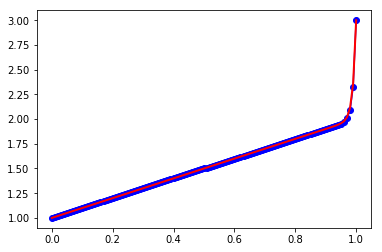

In [370]:
alpha = 1
beta = 3
epsilon = 0.01
error, x, U, u = FDM_BVP(99, 0, 1, alpha, beta, epsilon, Dirichlet_bc, fun, exact_fun)

print ("max norm error: %7.2e" % error )
# let us plot the approximation solution in blue, and the exact solution in red
#plt.plot(x, u, 'ro-')
plt.plot(x, U, 'bo-')
number = 101
draw_fun(number, alpha, beta, epsilon)

In [379]:
def generate_grid_nonuni(left, right, mid, m):
    x = np.zeros(m+2)
    left_points = 10
    x[:left_points] = np.linspace(left, mid, left_points, endpoint=False)
    x[left_points:] = np.linspace(mid, right, m+2-left_points)
    return  x

In [380]:
x = generate_grid_nonuni(0., 1., 0.9, 19)
print (x)

[0.   0.09 0.18 0.27 0.36 0.45 0.54 0.63 0.72 0.81 0.9  0.91 0.92 0.93
 0.94 0.95 0.96 0.97 0.98 0.99 1.  ]


In [381]:
def FDM_BVP(m, left, right, alpha, beta, epsilon, bc, fun, exact_fun):
    # generate the grid
    x = generate_grid_nonuni(left, right, 0.90, m)
    #
    U = np.zeros(m+2)
    # 
    A = generate_A_interior_nonuni(epsilon, m, x)
    #print (A)
    F = generate_F_interior(m, x, fun)
    #print (F)
    # bc
    A, F = bc(A, F, alpha, beta, fun)
    #print (A)
    #print (F)
    U = np.linalg.solve(A, F)
    
    u = exact_fun(x, alpha, beta, epsilon)
    return np.max(np.abs(U-u)), x, U, u

0 0.0 1.9206858326015208e-14
1 0.09 2.3989994322626274e-05
2 0.18 1.3708568214365613e-05
3 0.27 4.553203005808193e-05
4 0.36 4.756033865538356e-05
5 0.44999999999999996 9.872766932339516e-05
6 0.54 0.00013115348607217747
7 0.63 0.00023008832954940495
8 0.72 0.00033757738140427485
9 0.8099999999999999 0.000554463132617089
10 0.9 0.0008927179482620673
11 0.9018867924528302 0.0008929568397648691
12 0.9037735849056604 0.000893239091512843
13 0.9056603773584906 0.0008935724060765704
14 0.9075471698113208 0.0008939658143813922
15 0.909433962264151 0.0008944298950617213
16 0.9113207547169812 0.0008949770276014402
17 0.9132075471698113 0.0008956216838174047
18 0.9150943396226415 0.000896380762694271
19 0.9169811320754717 0.0008972739739856461
20 0.9188679245283019 0.0008983242763864752
21 0.9207547169811321 0.0008995583763848902
22 0.9226415094339623 0.0009010072940756064
23 0.9245283018867925 0.0009027070022089578
24 0.9264150943396227 0.0009046991444656705
25 0.9283018867924528 0.00090703183

0.01

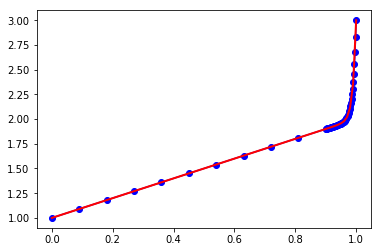

In [383]:
alpha = 1
beta = 3
epsilon = 0.01
error, x, U, u = FDM_BVP(62, 0, 1, alpha, beta, epsilon, Dirichlet_bc, fun, exact_fun)

for i in range(np.size(x)):
    print (i, x[i], np.abs(U[i]-u[i]))
print ("max norm error: %7.2e" % error )
# let us plot the approximation solution in blue, and the exact solution in red
#plt.plot(x, u, 'ro-')
plt.plot(x, U, 'bo-')
number = 101
draw_fun(number, alpha, beta, epsilon)

In [327]:
m = 100
sigma = 0.1
x = np.zeros(m+1)
for i in range(m):
    x[i+1] = np.exp(sigma*(i+1 - m))
x = (1 - x)
x = x[::-1]
#print(x)

def generate_geometric_grad_grid(left, right, sigma, m): 
    x = np.zeros(m+1)
    for i in range(m):
        x[i+1] = np.exp(sigma*(i+1 - m))
    x = (1 - x)
    x = x[::-1]
    return x

x = generate_geometric_grad_grid(0, 1, 0.1, 100)
print (np.diff(x))

[9.51625820e-02 8.61066650e-02 7.79125324e-02 7.04981746e-02
 6.37893863e-02 5.77190236e-02 5.22263323e-02 4.72563397e-02
 4.27593044e-02 3.86902186e-02 3.50083575e-02 3.16768718e-02
 2.86624189e-02 2.59348291e-02 2.34668038e-02 2.12336422e-02
 1.92129939e-02 1.73846358e-02 1.57302690e-02 1.42333360e-02
 1.28788550e-02 1.16532699e-02 1.05443146e-02 9.54089043e-03
 8.63295467e-03 7.81142041e-03 7.06806547e-03 6.39545011e-03
 5.78684257e-03 5.23615169e-03 4.73786597e-03 4.28699842e-03
 3.87903658e-03 3.50989744e-03 3.17588654e-03 2.87366098e-03
 2.60019598e-03 2.35275461e-03 2.12886041e-03 1.92627256e-03
 1.74296349e-03 1.57709858e-03 1.42701781e-03 1.29121911e-03
 1.16834336e-03 1.05716079e-03 9.56558643e-04 8.65530053e-04
 7.83163978e-04 7.08636072e-04 6.41200434e-04 5.80182145e-04
 5.24970514e-04 4.75012964e-04 4.29809504e-04 3.88907722e-04
 3.51898259e-04 3.18410712e-04 2.88109927e-04 2.60692642e-04
 2.35884457e-04 2.13437083e-04 1.93125859e-04 1.74747504e-04
 1.58118080e-04 1.430711

In [392]:
def FDM_BVP(m, left, right, alpha, beta, epsilon, bc, fun, exact_fun):
    # generate the grid
    x = generate_geometric_grad_grid(left, right, 0.1, m+1)
    #
    U = np.zeros(m+2)
    # 
    A = generate_A_interior_nonuni(epsilon, m, x)
    #print (A)
    F = generate_F_interior(m, x, fun)
    #print (F)
    # bc
    A, F = bc(A, F, alpha, beta, fun)
    #print (A)
    #print (F)
    U = np.linalg.solve(A, F)
    
    u = exact_fun(x, alpha, beta, epsilon)
    return np.max(np.abs(U-u)), x, U, u

0 0.0 1.1102230246251565e-16
1 0.09516258196404048 0.004707989274533642
2 0.18126924692201818 0.0013057831671288156
3 0.2591817793182821 0.006753762822495402
4 1.0 0.0
max norm error: 6.75e-03
3


0.01

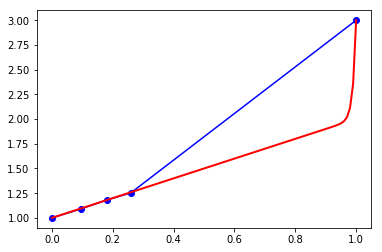

In [397]:
alpha = 1
beta = 3
epsilon = 0.01
error, x, U, u = FDM_BVP(3, 0, 1, alpha, beta, epsilon, Dirichlet_bc, fun, exact_fun)

for i in range(np.size(x)):
    print (i, x[i], np.abs(U[i]-u[i]))
print ("max norm error: %7.2e" % error )
print (np.argmax(np.abs(U - u)))
# let us plot the approximation solution in blue, and the exact solution in red
#plt.plot(x, u, 'ro-')
plt.plot(x, U, 'bo-')
number = 101
draw_fun(number, alpha, beta, epsilon)

In [386]:
def FDM_BVP_adaptive(coarse_m, refine_number, left, right, alpha, beta, epsilon, bc, fun, exact_fun):
    # generate the coarse grid
    x = np.linspace(left, right, coarse_m+2)
    #x = generate_geometric_grad_grid(0, 1, 0.16, coarse_m+1)
    for i in range(refine_number):
        m = np.size(x)-2
        #
        U = np.zeros(m+2)
        # 
        A = generate_A_interior_nonuni(epsilon, m, x)
        #print (A)
        F = generate_F_interior(m, x, fun)
        #print (F)
        # bc
        A, F = bc(A, F, alpha, beta, fun)
        #print (A)
        #print (F)
        U = np.linalg.solve(A, F)
        u = exact_fun(x, alpha, beta, epsilon)
        if (np.max(np.abs(U-u)) < 1.e-3):
            #print (i)
            return np.max(np.abs(U-u)), x, U, u
        else:
            #print (i, np.max(np.abs(U-u)))
            j = np.argmax(np.abs(U - u))
            #print (x)
            #print (j)
            x = np.insert(x, j, 0.5*(x[j-1]+x[j]))
            x = np.insert(x, j+2, 0.5*(x[j+1]+x[j+2]))
        #print (x)
    return np.max(np.abs(U-u)), x, U, u

In [360]:
alpha = 1
beta = 3
epsilon = 0.01

minimum_m = np.zeros(50)
for m in range(1, 51):
    error, x, U, u = FDM_BVP_adaptive(m, 50, 0, 1, alpha, beta, epsilon, Dirichlet_bc, fun, exact_fun)
    print (m, np.size(x), error)
    minimum_m[m-1] = np.size(x)

1 103 0.0010542091903531503
2 104 0.0010044392566708193
3 105 0.0021133198873846126
4 106 0.0009234143022163188
5 107 0.0005845763354541678
6 108 0.0008889070879130045
7 109 0.0014326908962170037
8 110 0.0007295012856149974
9 111 0.0006598734717664367
10 112 0.0007790040178712321
11 113 0.0007886169082309546
12 114 0.0005695772796450171
13 115 0.0005690760452945476
14 116 0.0008782284171711119
15 117 0.0013096355992310293
16 118 0.0007323588557570648
17 119 0.0005563603741820522
18 120 0.000634627953122413
19 121 0.0005673091082609716
20 122 0.0006398958352451523
21 123 0.0005147314075031328
22 124 0.0005643408376165837
23 125 0.0005675552295463238
24 126 0.0006391093243762747
25 127 0.00072089589434432
26 128 0.0005211349905187568
27 129 0.0005567466582290237
28 130 0.0005674394601409283
29 131 0.0007943461078956382
30 132 0.0005156665292844753
31 133 0.0005576906012347838
32 134 0.0005663554924983938
33 135 0.0006373683350338055
34 136 0.0006561683217358727
35 137 0.00055768462935823

In [347]:
print(minimum_m)
print(np.min(minimum_m), np.argmin(minimum_m))

[ 95.  60.  81.   8. 123.  86.  99.  94.  75.  98. 163. 126.  89. 106.
  95.  18.  19. 134. 139.  98. 107. 108.  99. 118. 101.  84.  95.  90.
  91.  68.  69.  68.  77.  82.  85.  88.  67.  72.  77.  82.  85.  62.
  67.  70.  77.  78.  85.  86.  91.  92.]
8.0 3


64
0.0009436696081630558
22


0.01

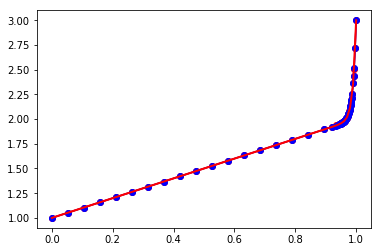

In [388]:
alpha = 1
beta = 3
epsilon = 0.01

error, x, U, u = FDM_BVP_adaptive(18, 100, 0, 1, alpha, beta, epsilon, Dirichlet_bc, fun, exact_fun)

print (np.size(x))
print (error)
#for i in range(np.size(x)):
#    print (i, x[i], np.abs(U[i]-u[i]))
#print ("max norm error: %7.2e" % error )
print (np.argmax(np.abs(U - u)))
# let us plot the approximation solution in blue, and the exact solution in red
plt.plot(x, u, 'ro-')
plt.plot(x, U, 'bo-')
number = 101
draw_fun(number, alpha, beta, epsilon)

In [324]:
x

array([0.        , 0.05      , 0.1       , ..., 0.99921875, 0.99960938,
       1.        ])

In [325]:
np.savetxt("1e-5.txt", x)